<a href="https://colab.research.google.com/github/MuhammedKocakKIT/cellpose/blob/main/notebooks/run_Cellpose-SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cellpose-SAM: superhuman generalization for cellular segmentation

Marius Pachitariu, Michael Rariden, Carsen Stringer

[paper](https://www.biorxiv.org/content/10.1101/2025.04.28.651001v1) | [code](https://github.com/MouseLand/cellpose)

This notebook shows how to process your own 2D or 3D images, saved on Google Drive.

This notebook is adapted from the notebook by Pradeep Rajasekhar, inspired by the [ZeroCostDL4Mic notebook series](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki).

### Make sure you have GPU access enabled by going to Runtime -> Change Runtime Type -> Hardware accelerator and selecting GPU

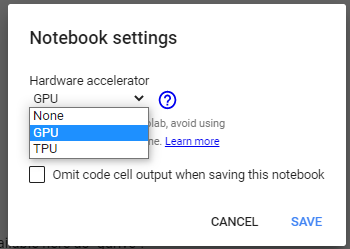

### Mount your google drive

Run this cell to connect your Google Drive to colab:
* Click on the URL.
* Sign in your Google Account.

You will either have to:
* copy the authorisation code and enter it into box below OR
* in the new google colab, you can just click "Allow" and it should connect.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



Then click on "Folder" icon on the Left, press the refresh button. Your Google Drive folder should now be available here as "gdrive".


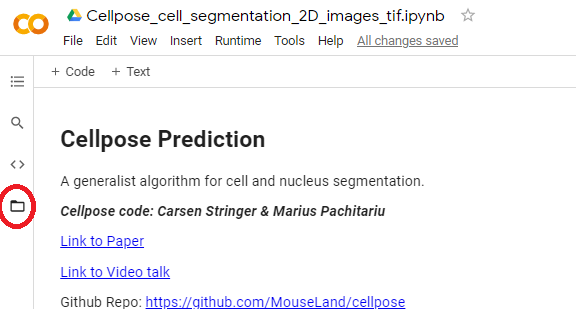

Click on the triangle icon and it will allow you to access whole drive. Navigate to the folder containing your images. Once you are there, click on the three dots on the right of the folder and select "Copy Path"

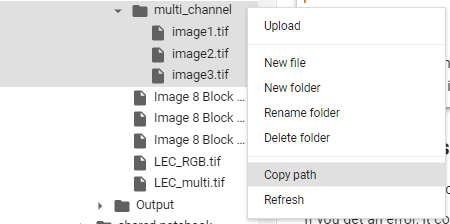

Copy and paste this path in the **dir** string below

### Install Cellpose-SAM


In [2]:
!pip install git+https://www.github.com/mouseland/cellpose.git

  Cloning https://www.github.com/mouseland/cellpose.git to /tmp/pip-req-build-jvsr674c
  Running command git clone --filter=blob:none --quiet https://www.github.com/mouseland/cellpose.git /tmp/pip-req-build-jvsr674c
  Resolved https://www.github.com/mouseland/cellpose.git to commit 9604421222c51d96636c2547e33fbd7d4f766c2a
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 84.8 MB/s eta 0:00:00
  Created wheel for cellpose: filename=cellpose-4.0.8.dev24+g960442122-py3-none-any.whl size=212893 sha256=5c319651e262b28c5ef850b391bbe0f9b4af1b9c0885917ebe3153b5bfb24daa
  Stored in directory: /tmp/pip-ephem-wheel-cache-8d9deiif/wheels/df/b6/31/a3013c44290eabb46f4c06d1efb19744124fcad2d59684ec5e
Successfully built cellpose


Check GPU and instantiate model - will download weights.

In [3]:
import numpy as np
from cellpose import models, core, io, plot
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt
from natsort import natsorted

io.logger_setup() # run this to get printing of progress

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

model = models.CellposeModel(gpu=True)

creating new log file
2025-11-26 13:41:38,860 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2025-11-26 13:41:38,861 [INFO] 
cellpose version: 	4.0.8.dev24+g960442122 
platform:       	linux 
python version: 	3.12.12 
torch version:  	2.9.0+cu126
2025-11-26 13:41:39,082 [INFO] ** TORCH CUDA version installed and working. **
2025-11-26 13:41:39,083 [INFO] ** TORCH CUDA version installed and working. **
2025-11-26 13:41:39,084 [INFO] >>>> using GPU (CUDA)
2025-11-26 13:41:42,071 [INFO] Downloading: "https://huggingface.co/mouseland/cellpose-sam/resolve/main/cpsam" to /root/.cellpose/models/cpsam



100%|██████████| 1.15G/1.15G [00:04<00:00, 258MB/s]


Input directory with your images:

In [4]:
# *** change to your google drive folder path ***
dir = "/content/drive/MyDrive/GeologicalImageSegmentation/"
dir = Path(dir)
if not dir.exists():
  raise FileNotFoundError("directory does not exist")

# *** change to your image extension ***
image_ext = ".tif"

# list all files
files = natsorted([f for f in dir.glob("*"+image_ext) if "_masks" not in f.name and "_flows" not in f.name])

if(len(files)==0):
  raise FileNotFoundError("no image files found, did you specify the correct folder and extension?")
else:
  print(f"{len(files)} images in folder:")

for f in files:
  print(f.name)

1 images in folder:
nature_rock_chip_p29_original.tif


## Run Cellpose-SAM on one image in folder

Here are some of the parameters you can change:

* ***flow_threshold*** is  the  maximum  allowed  error  of  the  flows  for  each  mask.   The  default  is 0.4.
    *  **Increase** this threshold if cellpose is not returning as many masks as you’d expect (or turn off completely with 0.0)
    *   **Decrease** this threshold if cellpose is returning too many ill-shaped masks.

* ***cellprob_threshold*** determines proability that a detected object is a cell.   The  default  is 0.0.
    *   **Decrease** this threshold if cellpose is not returning as many masks as you’d expect or if masks are too small
    *   **Increase** this threshold if cellpose is returning too many masks esp from dull/dim areas.

* ***tile_norm_blocksize*** determines the size of blocks used for normalizing the image. The default is 0, which means the entire image is normalized together.
  You may want to change this to 100-200 pixels if you have very inhomogeneous brightness across your image.



In [5]:
img = io.imread(files[0])

print(f'your image has shape: {img.shape}. Assuming channel dimension is last with {img.shape[-1]} channels')

your image has shape: (4160, 6240, 3). Assuming channel dimension is last with 3 channels


### Channel Selection:

- Use the dropdowns below to select the _zero-indexed_ channels of your image to segment. The order does not matter. Remember to rerun the cell after you edit the dropdowns.

- If you have a histological image taken in brightfield, you don't need to adjust the channels.

- If you have a fluroescent image with multiple stains, you should choose one channel with a cytoplasm/membrane stain, one channel with a nuclear stain, and set the third channel to `None`. Choosing multiple channels may produce segmentaiton of all the structures in the image. If you have retrained the model on your data with a thrid stain (described below), you can run segmentation with all channels.

In [6]:
first_channel = '0' # @param ['None', 0, 1, 2, 3, 4, 5]
second_channel = '1' # @param ['None', 0, 1, 2, 3, 4, 5]
third_channel = '2' # @param ['None', 0, 1, 2, 3, 4, 5]

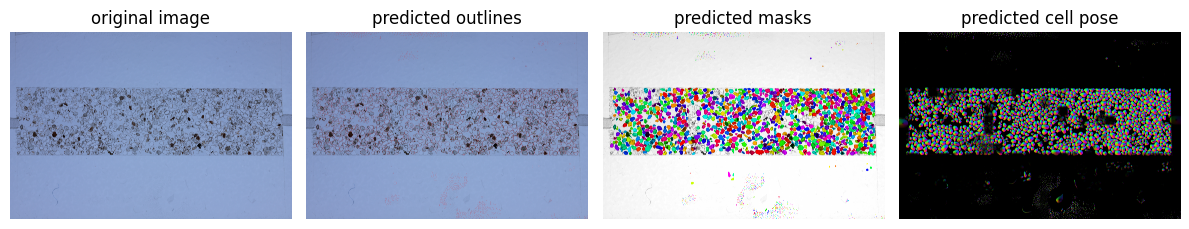

In [7]:
selected_channels = []
for i, c in enumerate([first_channel, second_channel, third_channel]):
  if c == 'None':
    continue
  # Check if the image has channels to begin with
  if img.ndim > 2 and int(c) >= img.shape[-1]:
      assert False, 'invalid channel index, must have index greater or equal to the number of channels'
  # Handle single channel image case
  if img.ndim == 2 and int(c) != 0:
      assert False, 'invalid channel index for grayscale image, must be 0 or None'
  if c != 'None':
      selected_channels.append(int(c))

# Adjust image indexing based on whether channels were selected and image dimension
if selected_channels and img.ndim > 2:
    img_selected_channels = np.zeros_like(img)
    img_selected_channels[:, :, :len(selected_channels)] = img[:, :, selected_channels]
elif img.ndim == 2:
    # If the image is grayscale, use it directly
    img_selected_channels = img
else:
    # If no channels are selected but the image has channels, use all channels
    img_selected_channels = img


flow_threshold = 0.4
cellprob_threshold = 0.0
tile_norm_blocksize = 0

masks, flows, styles = model.eval(img_selected_channels, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img_selected_channels, masks, flows[0])
plt.tight_layout()
plt.show()

## Kocak - Save the mask for the sample image


Mask saved to: /content/drive/MyDrive/GeologicalImageSegmentation/nature_rock_chip_p29_original_mask.tif


## Run Cellpose-SAM on folder of images

if you have many large images, you may want to run them as a loop over images



In [ ]:
masks_ext = ".png" if image_ext == ".png" else ".tif"
for i in trange(len(files)):
    f = files[i]
    img = io.imread(f)
    masks, flows, styles = model.eval(img, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})
    io.imsave(dir / (f.stem + "_masks" + masks_ext), masks)

if you have small images, you may want to load all of them first and then run, so that they can be batched together on the GPU

In [ ]:
print("loading images")
imgs = [io.imread(files[i]) for i in trange(len(files))]

print("running cellpose-SAM")
masks, flows, styles = model.eval(imgs, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})

print("saving masks")
for i in trange(len(files)):
    f = files[i]
    io.imsave(dir / (f.stem + "_masks" + masks_ext), masks[i])

to save your masks for ImageJ, run the following code:

In [ ]:
for i in trange(len(files)):
    f = files[i]
    masks0 = io.imsave(dir / (f.name + "_masks" + masks_ext))
    io.save_rois(masks0, f)

  0%|          | 0/1 [00:00<?, ?it/s]


NameError: name 'masks_ext' is not defined

# Task
To visualize the overlay of the ground truth and Cellpose-SAM masks on the original image, we'll first load the ground truth image, convert both masks to a binary format, and then overlay them on the original image with different colors and transparency.

**Steps:**
1.  **Construct Ground Truth Filename**: Create the filename for the ground truth mask by appending `_gt` to the original image's stem.
2.  **Load Ground Truth Mask**: Read the ground truth image, which is a 16-bit image with foreground pixels having a value of 70.
3.  **Create Binary Ground Truth Mask**: Convert the ground truth mask into a binary mask (1s for foreground, 0s for background).
4.  **Create Binary Cellpose-SAM Mask**: Convert the Cellpose-SAM output mask (stored in the `masks` variable) into a binary mask (1s for segmented regions, 0s for background).
5.  **Visualize Overlays**:
    *   Display the `img` (original image).
    *   Overlay the binary ground truth mask in transparent green.
    *   Overlay the binary Cellpose-SAM mask in transparent red.

# Task
To visualize the overlay of the ground truth and Cellpose-SAM masks on the original image, I will perform the following steps:
1. Load the ground truth mask and convert it to a binary format.
2. Convert the Cellpose-SAM output mask to a binary format.
3. Display the original image.
4. Overlay the binary ground truth mask in transparent green.
5. Overlay the binary Cellpose-SAM mask in transparent red.

This will allow for a clear visual comparison of the two segmentation results against the original image.

```python
import matplotlib.pyplot as plt
import numpy as np
from cellpose import io

# Assuming img, masks, and dir are already defined from previous cells.
# For demonstration purposes, if not already in kernel, these would be loaded:
# img = io.imread(files[0])
# gt_filename = files[0].stem + '_gt' + image_ext
# ground_truth_mask = io.imread(dir / gt_filename)
# masks is already defined from model.eval()

# 1. Read ground truth image and convert to binary mask (if not already done)
# The ground_truth_mask from the kernel is 16-bit, with foreground 70 and background 0
# Create a binary mask where 70 (foreground) becomes 1, and 0 (background) remains 0.
if 'ground_truth_mask' not in locals() or 'ground_truth_mask' not in globals():
    gt_filename = files[0].stem + '_gt' + image_ext
    ground_truth_mask = io.imread(dir / gt_filename)
    binary_ground_truth_mask = (ground_truth_mask == 70).astype(np.uint8)
else:
    # Use the existing binary_ground_truth_mask if it's already in the kernel
    pass # binary_ground_truth_mask already exists in kernel from scratchpad execution

# 2. Convert Cellpose-SAM mask to binary (if not already done)
# Cellpose-SAM 'masks' output contains unique integer labels for each segmented object.
# To create a binary mask, we set any non-zero pixel to 1.
if 'binary_cellpose_sam_mask' not in locals() or 'binary_cellpose_sam_mask' not in globals():
    binary_cellpose_sam_mask = (masks > 0).astype(np.uint8)
else:
    # Use the existing binary_cellpose_sam_mask if it's already in the kernel
    pass # binary_cellpose_sam_mask already exists in kernel from scratchpad execution

# 3. Visualize overlays
fig, ax = plt.subplots(figsize=(15, 15))

# Display the original image
ax.imshow(img)

# Overlay the binary ground truth mask in transparent green
# Create an RGBA image for the ground truth overlay
gt_overlay_rgba = np.zeros((*img.shape[:2], 4), dtype=np.float32)
alpha_gt = 0.3  # Transparency for ground truth mask
gt_overlay_rgba[binary_ground_truth_mask == 1, 1] = 1.0  # Green channel
gt_overlay_rgba[binary_ground_truth_mask == 1, 3] = alpha_gt  # Alpha channel
ax.imshow(gt_overlay_rgba)

# Overlay the binary Cellpose-SAM mask in transparent red
# Create an RGBA image for the Cellpose-SAM overlay
cpsam_overlay_rgba = np.zeros((*img.shape[:2], 4), dtype=np.float32)
alpha_cpsam = 0.3  # Transparency for Cellpose-SAM mask
cpsam_overlay_rgba[binary_cellpose_sam_mask == 1, 0] = 1.0  # Red channel
cpsam_overlay_rgba[binary_cellpose_sam_mask == 1, 3] = alpha_cpsam  # Alpha channel
ax.imshow(cpsam_overlay_rgba)

ax.set_title('Original Image with Ground Truth (Green) and Cellpose-SAM (Red) Overlays')
ax.axis('off')
plt.show()

```

## Read ground truth image

### Subtask:
Load the ground truth image based on the original image filename by appending '_gt' before the extension.


**Reasoning**:
First, I'll construct the filename for the ground truth mask based on the first image file's stem, appending '_gt' and using the existing image extension. Then, I'll load the ground truth image using `io.imread()` and store it in the `ground_truth_mask` variable. This directly addresses the first two instructions of the subtask.



In [14]:
gt_filename = files[0].stem + '_gt' + image_ext
ground_truth_mask = io.imread(dir / gt_filename)
print(f"Ground truth mask loaded from: {dir / gt_filename}")
print(f"Ground truth mask shape: {ground_truth_mask.shape}")

Ground truth mask loaded from: /content/drive/MyDrive/GeologicalImageSegmentation/nature_rock_chip_p29_original_gt.tif
Ground truth mask shape: (4160, 6240)


## Create Binary Ground Truth Mask

### Subtask:
Convert the loaded `ground_truth_mask` into a binary mask (1s for foreground, 0s for background). The foreground pixels in the `ground_truth_mask` have a value of 70.

#### Instructions
1. Create a binary mask named `binary_ground_truth_mask` by checking where `ground_truth_mask` is equal to 70 and casting the result to `np.uint8`.

**Reasoning**:
Following the instructions in the markdown block, I will convert the `ground_truth_mask` into a binary mask where foreground pixels (value 70) are set to 1 and background to 0.



In [15]:
binary_ground_truth_mask = (ground_truth_mask == 70).astype(np.uint8)
print(f"Binary ground truth mask created with shape: {binary_ground_truth_mask.shape}")
print(f"Unique values in binary ground truth mask: {np.unique(binary_ground_truth_mask)}")

Binary ground truth mask created with shape: (4160, 6240)
Unique values in binary ground truth mask: [0 1]


## Create Binary Cellpose-SAM Mask

### Subtask:
Convert the Cellpose-SAM output mask (stored in the `masks` variable) into a binary mask (1s for segmented regions, 0s for background).

#### Instructions
1. Create a binary mask named `binary_cellpose_sam_mask` by checking where `masks` (the Cellpose-SAM output) is greater than 0 and casting the result to `np.uint8`.

**Reasoning**:
Following the instructions in the markdown block, I will convert the `masks` output from Cellpose-SAM into a binary mask where segmented regions (non-zero values) are set to 1 and the background to 0. This prepares the mask for overlay visualization.



In [16]:
binary_cellpose_sam_mask = (masks > 0).astype(np.uint8)
print(f"Binary Cellpose-SAM mask created with shape: {binary_cellpose_sam_mask.shape}")
print(f"Unique values in binary Cellpose-SAM mask: {np.unique(binary_cellpose_sam_mask)}")

Binary Cellpose-SAM mask created with shape: (4160, 6240)
Unique values in binary Cellpose-SAM mask: [0 1]


## Visualize Overlays

### Subtask:
Visualize the original image (`img`) with the `binary_ground_truth_mask` overlaid in transparent green and the `binary_cellpose_sam_mask` overlaid in transparent red.

#### Instructions
1.  Create a Matplotlib figure and axes.
2.  Display the original `img` on the axes.
3.  Create an RGBA overlay for the `binary_ground_truth_mask`: set the green channel to 1.0 and the alpha channel to a transparency value (e.g., 0.3) for pixels where the binary mask is 1. Overlay this on the original image.
4.  Create an RGBA overlay for the `binary_cellpose_sam_mask`: set the red channel to 1.0 and the alpha channel to a transparency value (e.g., 0.3) for pixels where the binary mask is 1. Overlay this on the original image.
5.  Set the title of the plot to 'Original Image with Ground Truth (Green) and Cellpose-SAM (Red) Overlays'.
6.  Turn off the axes for a cleaner visualization.
7.  Display the plot.

**Reasoning**:
I will generate the Python code to visualize the original image with the binary ground truth mask in transparent green and the binary Cellpose-SAM mask in transparent red, following the instructions from the previous markdown block.



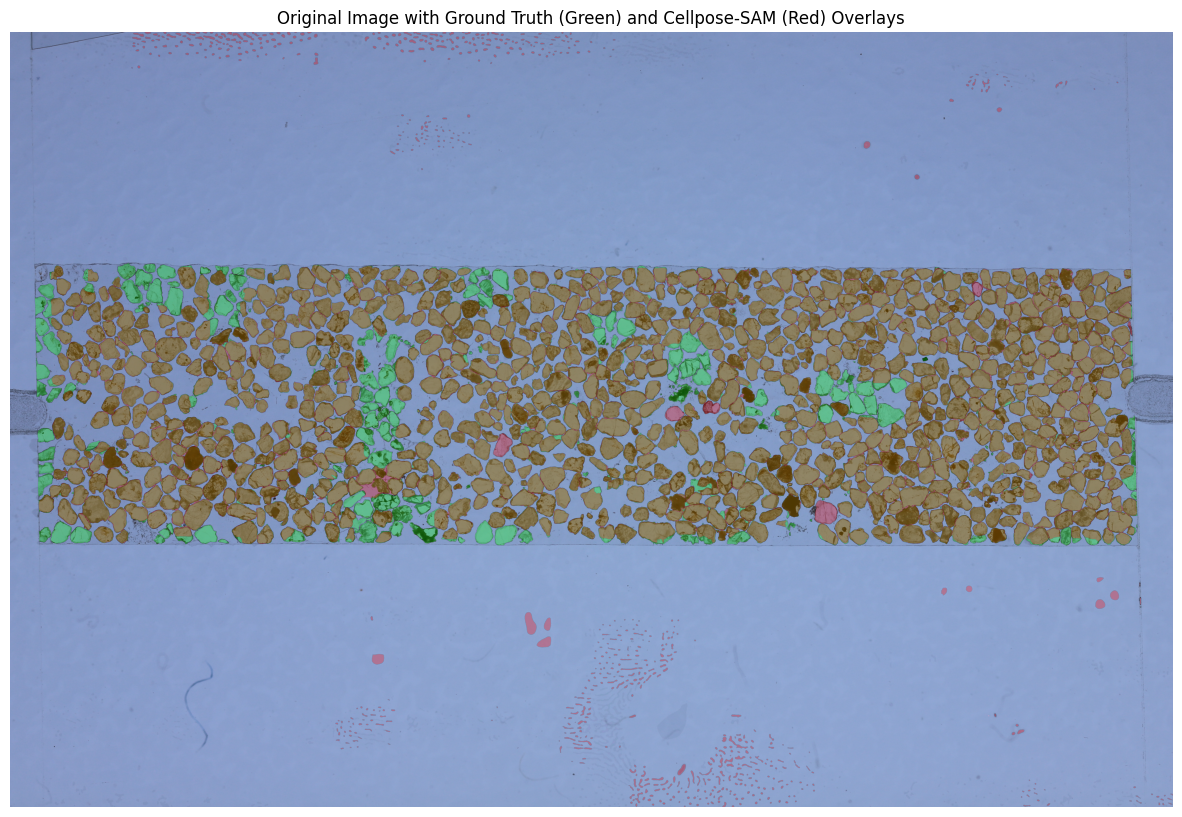

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Create a Matplotlib figure and axes
fig, ax = plt.subplots(figsize=(15, 15))

# Display the original img
ax.imshow(img)

# Create an RGBA overlay for the binary ground truth mask
gt_overlay_rgba = np.zeros((*img.shape[:2], 4), dtype=np.float32)
alpha_gt = 0.3  # Transparency for ground truth mask
gt_overlay_rgba[binary_ground_truth_mask == 1, 1] = 1.0  # Green channel
gt_overlay_rgba[binary_ground_truth_mask == 1, 3] = alpha_gt  # Alpha channel
ax.imshow(gt_overlay_rgba)

# Create an RGBA overlay for the binary Cellpose-SAM mask
cpsam_overlay_rgba = np.zeros((*img.shape[:2], 4), dtype=np.float32)
alpha_cpsam = 0.3  # Transparency for Cellpose-SAM mask
cpsam_overlay_rgba[binary_cellpose_sam_mask == 1, 0] = 1.0  # Red channel
cpsam_overlay_rgba[binary_cellpose_sam_mask == 1, 3] = alpha_cpsam  # Alpha channel
ax.imshow(cpsam_overlay_rgba)

# Set the title and turn off axes
ax.set_title('Original Image with Ground Truth (Green) and Cellpose-SAM (Red) Overlays')
ax.axis('off')

# Display the plot
plt.show()

## Summary:

### Data Analysis Key Findings
*   The ground truth mask was successfully loaded from `/content/drive/MyDrive/GeologicalImageSegmentation/nature_rock_chip_p29_original_gt.tif` with a shape of `(4160, 6240)`.
*   Both the ground truth mask and the Cellpose-SAM output mask were converted into binary formats (0s for background, 1s for foreground) and both retained the original shape of `(4160, 6240)`.
*   A visualization was successfully created, overlaying the original image with the binary ground truth mask in transparent green and the binary Cellpose-SAM mask in transparent red, enabling a direct visual comparison.

### Insights or Next Steps
*   The visual comparison allows for an immediate assessment of areas where Cellpose-SAM aligns well or deviates from the ground truth.
*   To quantitatively evaluate the performance of Cellpose-SAM, calculate standard segmentation metrics such as Intersection over Union (IoU) or Dice coefficient between the binary ground truth and Cellpose-SAM masks.


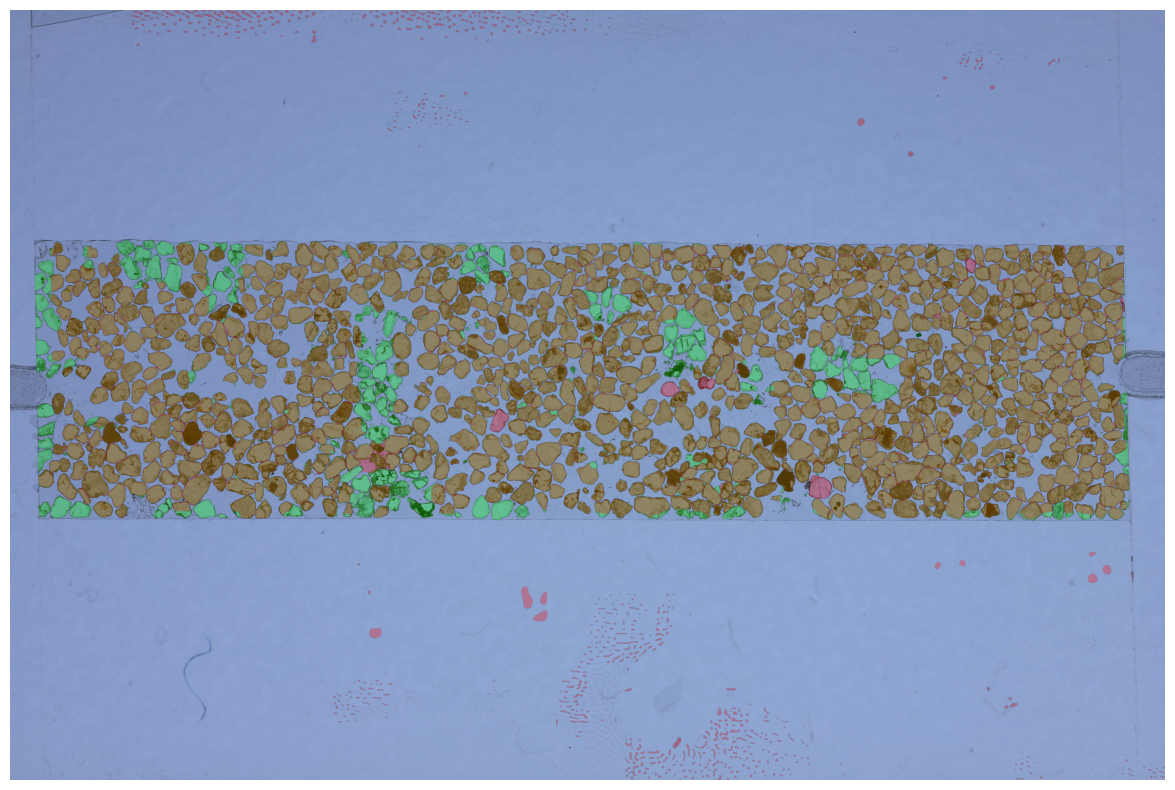

Overlayed figure saved to: /content/drive/MyDrive/GeologicalImageSegmentation/nature_rock_chip_p29_original_qualitative.tif


In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Create a Matplotlib figure and axes, matching the aspect ratio of the original image
fig, ax = plt.subplots(figsize=(15, 10)) # Adjusted figsize to match img aspect ratio (6240/4160 = 1.5)

# Display the original img
ax.imshow(img)

# Create an RGBA overlay for the binary ground truth mask
gt_overlay_rgba = np.zeros((*img.shape[:2], 4), dtype=np.float32)
alpha_gt = 0.3  # Transparency for ground truth mask
gt_overlay_rgba[binary_ground_truth_mask == 1, 1] = 1.0  # Green channel
gt_overlay_rgba[binary_ground_truth_mask == 1, 3] = alpha_gt  # Alpha channel
ax.imshow(gt_overlay_rgba)

# Create an RGBA overlay for the binary Cellpose-SAM mask
cpsam_overlay_rgba = np.zeros((*img.shape[:2], 4), dtype=np.float32)
alpha_cpsam = 0.3  # Transparency for Cellpose-SAM mask
cpsam_overlay_rgba[binary_cellpose_sam_mask == 1, 0] = 1.0  # Red channel
cpsam_overlay_rgba[binary_cellpose_sam_mask == 1, 3] = alpha_cpsam  # Alpha channel
ax.imshow(cpsam_overlay_rgba)

# Remove the title and turn off axes for a cleaner visualization
ax.set_title('')
ax.axis('off')

# Calculate DPI to match original image resolution
# Original image dimensions: img.shape[1] (width), img.shape[0] (height)
# Figure size: 15 inches (width), 10 inches (height)
dpi = img.shape[1] / 15 # or img.shape[0] / 10

# Save the figure as a TIFF image with the calculated DPI
output_filename = files[0].stem + '_qualitative.tif'
output_path = dir / output_filename
plt.savefig(output_path, dpi=dpi, bbox_inches='tight', pad_inches=0)

# Display the plot
plt.show()
print(f"Overlayed figure saved to: {output_path}")